In [ ]:
# Install dependencies
!pip install kaggle pandas scikit-learn pyarrow

In [ ]:
# Configure Kaggle API & download dataset OCR-Indonesia
# 1) Upload file `kaggle.json` (API token) via Files pane
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 2) Download & unzip
!kaggle datasets download -d pandupt/ocr-dataset-indonesia -p /content/ocr_indonesia --unzip


Dataset URL: https://www.kaggle.com/datasets/pandupt/ocr-dataset-indonesia
License(s): apache-2.0
 96% 447M/468M [00:03<00:00, 119MB/s] 
100% 468M/468M [00:03<00:00, 124MB/s]


In [ ]:
# Parse HF-style JSONL → DataFrame df_items
import json, ast
import pandas as pd

ann_path = "/content/ocr_indonesia/data/annotations/huggingface_train.jsonl"
rows = []
with open(ann_path, "r", encoding="utf-8") as f:
    for line in f:
        rec   = json.loads(line)
        rid   = rec["id"]
        outer = json.loads(rec["parsed_data"])
        s     = outer["json"]
        # strip wrapping quotes, un-escape backslashes
        if s.startswith('"') and s.endswith('"'):
            s = s[1:-1]
        s = s.encode("utf-8").decode("unicode_escape")
        try:
            inner = ast.literal_eval(s)
        except:
            continue
        for li in inner.get("line_items", []):
            if isinstance(li, dict):
                item   = li.get("item_name","").strip()
                amount = li.get("item_value","").replace(".","").replace(",","")
                if item and amount.isdigit():
                    rows.append({
                        "receipt_id": rid,
                        "item":       item,
                        "amount":     int(amount)
                    })

df_items = pd.DataFrame(rows)
print(f"✅ Extracted {len(df_items)} line‐items")
df_items.head(10)


✅ Extracted 7038 line‐items


,receipt_id,item,amount
0,0,Nasi Campur Bali,75000
1,0,Bbk Bengil Nasi,125000
2,0,MilkShake Starwb,37000
3,0,Ice Lemon Tea,24000
4,0,Nasi Ayam Dewata,70000
5,0,Free Ice Tea,0
6,0,Organic Green Sa,65000
7,0,Ice Tea,18000
8,0,Ice Orange,29000
9,0,Ayam Suir Bali,85000


In [ ]:
# Auto‐generate labels (heuristic keyword‐based)
import pandas as pd

keywords = {
    'makanan': [
        'nasi', 'ayam', 'mie', 'roti', 'sate', 'ikan', 'bakso', 'burger', 'pizza', 'kue',
        'tahu', 'tempe', 'soto', 'rendang', 'lumpia', 'risol', 'pastry', 'brownie',
        'donat', 'croissant', 'pie', 'cake', 'bubur', 'kwetiau', 'udang', 'cumi',
        'seafood', 'sushi', 'ramen', 'udon', 'spaghetti', 'pasta', 'goreng', 'bebek',
        'bbk', 'spaghetti', 'bolognase', 'wagyu', 'bakpia', 'kacang', 'toblerone',
        'beef', 'crepes', 'nila', 'gurame', 'sop', 'bakar', 'fried', 'siomay', 'udang'
        'udg', 'telur', 'tlur', 'tlr', 'telor', 'bihun', 'meatball', 'donut', 'potato',
        'octopus', 'gurita', 'satay', 'bacon', 'karaage','karage', 'chicken', 'katsu',
        'rice',
    ],
    'minuman': [
        'air', 'aqua', 'teh', 'kopi', 'jus', 'soda', 'es', 'milkshake', 'smoothie',
        'latte', 'mocha', 'cappuccino', 'boba', 'bubble', 'mineral water', 'juice',
        'cola', 'fanta', 'sprite', 'ice', 'iced', 'tea', 'coffee', 'ocha', 'milk',
        'drink'
    ],
    'atk': [
        'pulpen', 'pensil', 'notebook', 'kertas', 'stapler', 'penghapus', 'spidol',
        'map', 'folder', 'paper', 'clip'
    ],
    'transport': [
        'ojek', 'taksi', 'bus', 'kereta', 'grab', 'gojek', 'parking', 'tiket', 'fare',
        'transport', 'charge', 'gojek'
    ],
    'hiburan': [
        'bioskop', 'netflix', 'game', 'konser', 'musik', 'film', 'movie', 'karaoke',
        'teater', 'museum'
    ],
    'kesehatan': [
        'apotik', 'obat', 'vitamin', 'dokter', 'clinic', 'medicine', 'tablet',
        'supplement', 'bpjs', 'lab', 'sakatonik'
    ]
}

def auto_label(item: str) -> str:
    s = item.lower()
    for cat, kws in keywords.items():
        if any(kw in s for kw in kws):
            return cat
    return 'lain‐lain'

labels_df = pd.DataFrame({'item': df_items['item'].unique()})
labels_df['category'] = labels_df['item'].apply(auto_label)
labels_df.to_csv('qrep_labels.csv', index=False)
print(f"✅ Auto‐generated qrep_labels.csv with {len(labels_df)} items")
labels_df.head(200)


✅ Auto‐generated qrep_labels.csv with 5763 items


,item,category
0,Nasi Campur Bali,makanan
1,Bbk Bengil Nasi,makanan
2,MilkShake Starwb,minuman
3,Ice Lemon Tea,minuman
4,Nasi Ayam Dewata,makanan
...,...,...
195,ALMOND CREAM CHEESE,minuman
196,CK.MANTAP A,lain‐lain
197,CHEESE B,minuman
198,TAKE AWAY,lain‐lain


In [ ]:
# Merge df_items + labels → final training set
data = df_items.merge(labels_df, on="item")
print(f"✅ Merged dataset: {len(data)} rows")
data.head(100)


✅ Merged dataset: 7038 rows


,receipt_id,item,amount,category
0,0,Nasi Campur Bali,75000,makanan
1,0,Bbk Bengil Nasi,125000,makanan
2,0,MilkShake Starwb,37000,minuman
3,0,Ice Lemon Tea,24000,minuman
4,0,Nasi Ayam Dewata,70000,makanan
...,...,...,...,...
95,132,ZAI.Milk Choco Egg Avenger60gr,5363600,minuman
96,132,ZAI.Milk Choco Egg Frozen 60gr,5363600,minuman
97,133,TWIST STRAWBERRY DONUT,10000,makanan
98,133,TLJ CROQUETTE,17000,lain‐lain


In [ ]:
# TF-IDF + train/val split + Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection         import train_test_split
from sklearn.linear_model            import LogisticRegression
from sklearn.metrics                 import classification_report

# 1) Vectorize item names
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X = vectorizer.fit_transform(data["item"])
y = data["category"]

# 2) Split
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3) Train
clf = LogisticRegression(max_iter=1000)
clf.fit(Xtr, ytr)

# 4) Eval
ypr = clf.predict(Xte)
print("✅ Classification Report:\n")
print(classification_report(yte, ypr))


✅ Classification Report:

              precision    recall  f1-score   support

         atk       0.00      0.00      0.00         3
   kesehatan       0.00      0.00      0.00         3
   lain‐lain       0.75      1.00      0.86       920
     makanan       1.00      0.35      0.52       203
     minuman       0.97      0.38      0.55       274
   transport       0.00      0.00      0.00         5

    accuracy                           0.78      1408
   macro avg       0.45      0.29      0.32      1408
weighted avg       0.82      0.78      0.74      1408



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Test Model Tensorflow

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

In [ ]:
# Load data
df = pd.read_csv("qrep_labels.csv")
print(df.head())
print("Unique categories:", df['category'].nunique())


               item category
0  Nasi Campur Bali  makanan
1   Bbk Bengil Nasi  makanan
2  MilkShake Starwb  minuman
3     Ice Lemon Tea  minuman
4  Nasi Ayam Dewata  makanan
Unique categories: 6


In [ ]:
# Encode labels and split
# map category → integer
label2idx = {lab:i for i, lab in enumerate(sorted(df['category'].unique()))}
idx2label = {i:lab for lab,i in label2idx.items()}
df['label'] = df['category'].map(label2idx)

# train / val split (stratify supaya distribusi kategori terjaga)
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")


Train size: 4610, Val size: 1153


In [ ]:
# Build tf.data pipelines
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def df_to_dataset(dataframe):
    ds = tf.data.Dataset.from_tensor_slices((
        dataframe['item'].values,
        dataframe['label'].values
    ))
    ds = ds.shuffle(len(dataframe)).batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df)
val_ds   = df_to_dataset(val_df)


In [ ]:
# Text vectorization (tokenizer + integer encoding)
max_vocab = 10_000
max_len   = 64

vectorizer = TextVectorization(
    max_tokens=max_vocab,
    output_mode="int",
    output_sequence_length=max_len
)
# adapt only on train texts
vectorizer.adapt(train_ds.map(lambda text, lab: text))

# inspect
print("Vocab size:", len(vectorizer.get_vocabulary()))
print("Sample vectorized:", vectorizer(["nasi goreng ayam"]))


Vocab size: 4808
Sample vectorized: tf.Tensor(
[[4 5 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(1, 64), dtype=int64)


In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model, regularizers
from tensorflow.keras.layers import (
    InputLayer, Embedding, Bidirectional, LSTM,
    Dense, Dropout
)
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)
import matplotlib.pyplot as plt

# Build the model with regularization
num_classes = df['label'].nunique()
embed_dim   = 128
lstm_units  = 64
drop_rate   = 0.5
l2_strength = 1e-4

model = tf.keras.Sequential([
    InputLayer(input_shape=(1,), dtype=tf.string),
    vectorizer,  # TextVectorization layer
    Embedding(input_dim=max_vocab, output_dim=embed_dim, mask_zero=True),
    Dropout(drop_rate),
    Bidirectional(
        LSTM(lstm_units, dropout=drop_rate, recurrent_dropout=drop_rate)
    ),
    Dense(
        64,
        activation="relu",
        kernel_regularizer=regularizers.l2(l2_strength)
    ),
    Dropout(drop_rate),
    Dense(num_classes)  # logits
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 64)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 64, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,387,462 (5.29 MB)

 Trainable params: 1,387,462 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=2,
        verbose=1
    ),
    ModelCheckpoint(
        "best_model.h5",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]


# Train
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.6108 - loss: 1.5099
Epoch 1: val_loss improved from inf to 0.88497, saving model to best_model.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - accuracy: 0.6111 - loss: 1.5081 - val_accuracy: 0.6687 - val_loss: 0.8850 - learning_rate: 0.0010
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6898 - loss: 0.8559
Epoch 2: val_loss improved from 0.88497 to 0.79916, saving model to best_model.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 226ms/step - accuracy: 0.6898 - loss: 0.8558 - val_accuracy: 0.7173 - val_loss: 0.7992 - learning_rate: 0.0010
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7752 - loss: 0.5386
Epoch 3: val_loss improved from 0.79916 to 0.77804, saving model to best_model.h5


145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 230ms/step - accuracy: 0.7754 - loss: 0.5382 - val_accuracy: 0.7572 - val_loss: 0.7780 - learning_rate: 0.0010
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9081 - loss: 0.2640
Epoch 4: val_loss did not improve from 0.77804
145/145 ━━━━━━━━━━━━━━━━━━━━ 49s 337ms/step - accuracy: 0.9081 - loss: 0.2639 - val_accuracy: 0.7485 - val_loss: 0.8086 - learning_rate: 0.0010
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9550 - loss: 0.1577
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_loss did not improve from 0.77804
145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 310ms/step - accuracy: 0.9550 - loss: 0.1578 - val_accuracy: 0.7511 - val_loss: 0.8723 - learning_rate: 0.0010
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9879 - loss: 0.0840
Epoch 6: val_loss did not improve from 0.77804
145/145 ━━━━━━━━━━━━━━━━━━━━ 73s 250ms/step - accuracy: 0.9878 - loss: 0.0841 - val_ac

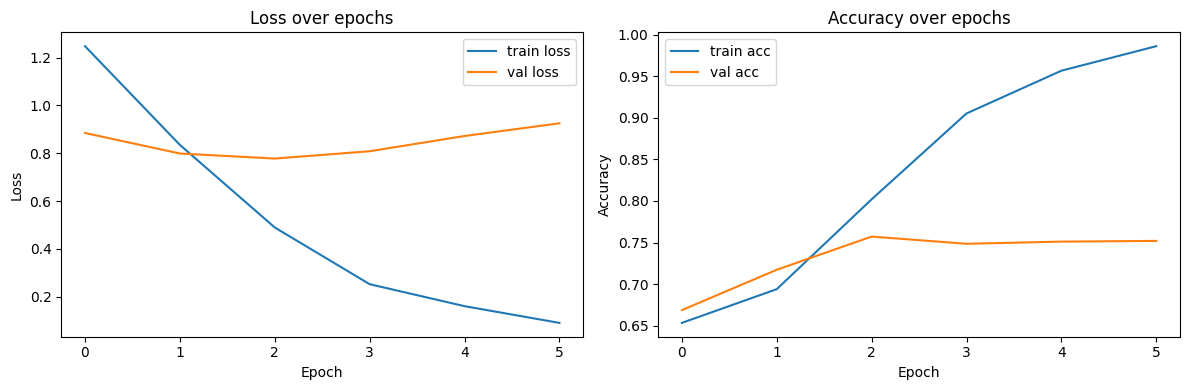

In [ ]:
plt.figure(figsize=(12,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history["loss"],   label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history["accuracy"],    label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate & inference demo
loss, acc = model.evaluate(val_ds)
print(f"Val loss: {loss:.3f},  Val acc: {acc:.3f}")

# inference test
def predict_category(text):
    logits = model.predict(tf.constant([text]))
    idx   = tf.argmax(logits[0]).numpy()
    return idx2label[idx]

for sample in ["Nasi Campur Bali", "AQUA", "Pulpen Joyko", "Go-Jek fee"]:
    print(sample, "→", predict_category(sample))


NameError: name 'model' is not defined